In [372]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import optim
import pyro
import pyro.distributions as dist

from tensorboardX import SummaryWriter

from tqdm import tqdm
import time


import numpy as np
import random
from numpy.random import *
import matplotlib.pyplot as plt 
#np.random.seed(100)
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import csv

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

seed = 1234
rng = np.random.RandomState(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'

In [373]:
x1 = np.random.binomial(1,0.5,size=70000)
x2 = np.random.normal(0.4*x1+0.5,0.2)
effect = 1.5
beta2 = 0.8
eps = 1e-10
b = np.random.normal(0,0.2)


def kaiki(x1=x1,x2=x2,effect=effect,beta2=beta2,b=b):
    return effect*x1+beta2*x2+b

yogo = kaiki(x1,x2)
data = np.array((x1,x2,yogo)).T

In [374]:
train_data = np.array(data[:60000])#train[:,0]:conditional, train[:,1]:feature, train[:,2]:outcome
test_data  = np.array(data[60000:])

0.3999336440742442
2.219005934227186
1.8190722901529417


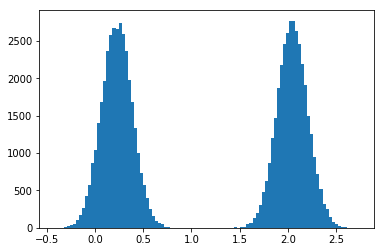

In [375]:
plt.hist(yogo, bins=100)
#x1=0のとき
untreat_group = beta2*np.random.normal(0.5,0.2,size=50000)+np.random.normal(0,0.2,size=50000)
print(untreat_group.mean())
#x1=1のとき
treat_group = (effect+beta2*np.random.normal(0.9,0.2, size=50000)+np.random.normal(0,0.2,size=50000))
print(treat_group.mean())
print(treat_group.mean()-untreat_group.mean())

(array([1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 6.000e+00, 7.000e+00, 1.600e+01, 5.000e+00,
        1.200e+01, 1.400e+01, 2.300e+01, 3.400e+01, 3.600e+01, 5.000e+01,
        4.300e+01, 5.100e+01, 8.100e+01, 9.900e+01, 1.070e+02, 1.480e+02,
        1.580e+02, 1.690e+02, 2.390e+02, 2.710e+02, 3.300e+02, 4.160e+02,
        4.180e+02, 4.850e+02, 5.320e+02, 6.230e+02, 7.120e+02, 7.120e+02,
        8.040e+02, 8.920e+02, 9.880e+02, 1.104e+03, 1.077e+03, 1.251e+03,
        1.298e+03, 1.259e+03, 1.412e+03, 1.497e+03, 1.541e+03, 1.500e+03,
        1.503e+03, 1.576e+03, 1.582e+03, 1.607e+03, 1.546e+03, 1.572e+03,
        1.478e+03, 1.540e+03, 1.395e+03, 1.364e+03, 1.350e+03, 1.232e+03,
        1.166e+03, 1.112e+03, 1.038e+03, 9.740e+02, 9.090e+02, 8.440e+02,
        7.430e+02, 6.760e+02, 6.050e+02, 5.380e+02, 4.890e+02, 4.160e+02,
        3.340e+02, 3.070e+02, 2.810e+02, 2.730e+02, 1.940e+02, 1.700e+02,
        1.240e+02, 1.070e+02, 8.600e+0

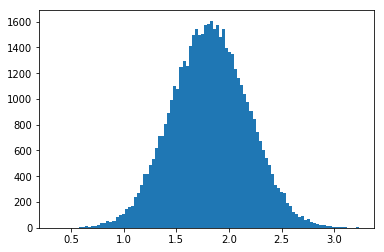

In [376]:
plt.hist(treat_group-untreat_group, bins=100)

In [377]:
batch_size = 100
num_iters = 6000
num_epochs = int(batch_size* num_iters/len(train_data))

In [378]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

In [379]:
num_epochs

10

In [380]:
from pixyz.distributions import Bernoulli, Normal
from pixyz.losses import KullbackLeibler
from pixyz.models import VAE

In [381]:
class Inference(Normal):
    def __init__(self, input_dim,cond_dim, hidden_dim, latent_dim):
        super(Inference, self).__init__(cond_var=["x","y"], var=["z"], name="q")
        
        self.fc1 = nn.Linear(input_dim+cond_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc31 = nn.Linear(hidden_dim, latent_dim)
        self.fc32 = nn.Linear(hidden_dim, latent_dim)
    def forward(self,x,y):
        h = F.relu(self.fc1(torch.cat([x,y],1)))
        h = F.relu(self.fc2(h))
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

class Generator(Normal):
    def __init__(self, latent_dim,cond_dim, hidden_dim, output_dim):
        super(Generator, self).__init__(cond_var=["z","y"], var=["x"], name="p")
        
        self.fc1 = nn.Linear(latent_dim+cond_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc31 = nn.Linear(hidden_dim, output_dim)
        self.fc32 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self,z,y):
        h = F.relu(self.fc1(torch.cat([z,y],1)))
        h = F.relu(self.fc2(h))
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}


In [382]:
input_dim = 1
hidden_dim = 100
latent_dim = 70
output_dim = 1
cond_dim = 2
estimate_dim =1

In [383]:
p = Generator(latent_dim,cond_dim, hidden_dim, output_dim)
q = Inference(input_dim,cond_dim, hidden_dim, latent_dim)


p.to(device)
q.to(device)


Inference(
  (fc1): Linear(in_features=3, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc31): Linear(in_features=100, out_features=70, bias=True)
  (fc32): Linear(in_features=100, out_features=70, bias=True)
)

In [384]:
loc = torch.tensor(0.)
scale = torch.tensor(1.)
prior = Normal(loc=loc, scale=scale, var=["z"], dim= latent_dim, name="p_prior")

In [385]:
kl = KullbackLeibler(q,prior)


In [386]:
model = VAE(q,p, regularizer = kl, optimizer=optim.Adam, optimizer_params={"lr":1e-3})

In [387]:
def data_shaper(x,y, input_dim):
    x = x.view(-1, input_dim).float()
    y = torch.eye(2)[y.long()].float()
    return x,y

def train(epoch, input_dim):
    train_loss = 0
    for _data in tqdm(train_loader):
        y = _data[:,0]
        x = _data[:,1]
        x, y = data_shaper(x, y, input_dim)
        x = x.to(device)
        y = y.to(device)
       
        loss = model.train({"x":x, "y":y})
        train_loss += loss
    #pytorchのlossはデフォルトでは平均の値になる。このためバッチ長をかけて
    #全体で割って全体のlossを計算する
    
    train_loss = train_loss * train_loader.batch_size / len(train_loader.dataset)
    print('Epoch:{} Train loss:{:.4f}'.format(epoch, train_loss))
    return train_loss

In [388]:
def test(epoch, input_dim):
    test_loss = 0
    for _data in test_loader:
        y = _data[:,0]
        x = _data[:,1]
        x, y = data_shaper(x,y, input_dim)
        x = x.to(device)
        y = y.to(device)
        
        loss = model.test({"x":x, "y":y})
        test_loss += loss
    test_loss = test_loss * test_loader.batch_size/ len(test_loader.dataset)
    print('Test loss:{:.4f}'.format(test_loss))
    return test_loss

In [389]:
def plot_reconstrunction(x,y,output_dim):
    with torch.no_grad():
        z = q.sample({"x":x, "y":y}, return_all=False)
        z.update({"y":y})
        recon_batch = p.sample_mean(z).view(-1, output_dim)
        recon = torch.cat([x.view(-1, output_dim), recon_batch]).cpu()
        return recon

def plot_image_from_latent(z,y, output_dim):
    with torch.no_grad():
        sample = p.sample_mean({"z":z, "y":y}).view(-1, output_dim).cpu()
        return sample

def plot_reconstraction_changing_y(x,y, output_dim):
    y_change = torch.eye(2)[range(2)].to(device)
    batch_dummy = torch.ones(x.size(0))[:, None].to(device)
    recon_all = []
    
    with torch.no_grad():
        for _y in y_change:
            z = q.sample({"x": x, "y": y}, return_all=False)   #batch数だけx,yを代入
            z.update({"y": batch_dummy * _y[None,:]})
            
            recon_batch = p.sample_mean(z).view(-1, output_dim)
            recon_all.append(recon_batch)
            
        recon_changing_y = torch.cat(recon_all)
        recon_changing_y = torch.cat([x.view( -1, output_dim), recon_changing_y]).cpu()
        
        return recon_changing_y

In [390]:
writer = SummaryWriter()

plot_number = 1

z_sample = 0.5 * torch.randn(64, latent_dim).to(device)
y_sample = torch.eye(2)[[plot_number]*64].to(device)

_data = iter(test_loader).next()

_y = _data[:,0]
_x = _data[:,1]
_x, _y = data_shaper(_x, _y, input_dim)
_x = _x.to(device)
_y = _y.to(device)

for epoch in range(1, num_epochs + 1):
    train_loss = train(epoch, input_dim)
    test_loss = test(epoch, input_dim)
    
    recon = plot_reconstrunction(_x[:8], _y[:8], output_dim)
    sample = plot_image_from_latent(z_sample, y_sample, output_dim)
    recon_changing_y = plot_reconstraction_changing_y(_x[:8], _y[:8], output_dim)
    

    writer.add_scalar('train_loss', train_loss.item(), epoch)
    writer.add_scalar('test_loss', test_loss.item(), epoch)      
    """
    writer.add_image('Image_from_latent', sample, epoch)
    writer.add_image('Image_reconstrunction', recon, epoch)
    writer.add_image('Image_reconstrunction_change_y', recon_changing_y, epoch)
    """
writer.close()

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:1 Train loss:0.0671
Test loss:-0.1547


100%|██████████| 600/600 [00:03<00:00, 160.54it/s]


Epoch:2 Train loss:-0.1612
Test loss:-0.1590


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:3 Train loss:-0.1687
Test loss:-0.1718


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:4 Train loss:-0.1704
Test loss:-0.1486


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:5 Train loss:-0.1750
Test loss:-0.1782


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:6 Train loss:-0.1763
Test loss:-0.1822


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:7 Train loss:-0.1785
Test loss:-0.1806


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:8 Train loss:-0.1781
Test loss:-0.1815


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:9 Train loss:-0.1811
Test loss:-0.1822


100%|██████████| 600/600 [00:03<00:00, 177.42it/s]


Epoch:10 Train loss:-0.1814
Test loss:-0.1811


In [391]:
_data= iter(train_loader).next()
_data = _data[:8]
y = _data[:,0]
x = _data[:,1]
x, y = data_shaper(x,y, input_dim)
x = x.to(device)
y = y.to(device)
print(x)
print(y)
test = plot_reconstraction_changing_y(x,y, output_dim).cpu().reshape(3,-1)
print(test)

tensor([[1.3615],
        [0.8118],
        [0.8521],
        [0.6296],
        [0.8544],
        [0.6359],
        [0.8814],
        [0.3827]], device='cuda:0')
tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], device='cuda:0')
tensor([[1.3615, 0.8118, 0.8521, 0.6296, 0.8544, 0.6359, 0.8814, 0.3827],
        [0.5112, 0.5535, 0.4899, 0.5035, 0.5250, 0.4901, 0.4871, 0.5051],
        [0.8563, 0.9126, 0.8951, 0.8827, 0.9124, 0.9729, 0.8886, 0.8339]])


In [392]:
pt_maker = torch.utils.data.DataLoader(dataset=train_data, batch_size = 10000, shuffle=True)
for _data in pt_maker:
    y = _data[:,0]
    x = _data[:,1]
    x, y = data_shaper(x,y, input_dim)
    x = x.to(device)
    y = y.to(device)
    gen_pt = plot_reconstraction_changing_y(x,y, output_dim).cpu().reshape(3,-1)


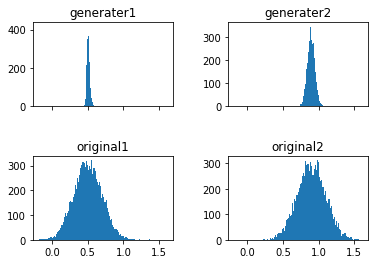

In [393]:
fig2, axes = plt.subplots(2, 2, sharex=True)
plt.subplots_adjust(wspace=0.4, hspace=0.6)
axes[0, 0].hist(gen_pt[1,:], bins=100)
axes[0, 0].set_title('generater1')
axes[0, 1].hist(gen_pt[2,:], bins=100) 
axes[0, 1].set_title('generater2')
axes[1, 0].hist(np.random.normal(0.5,0.2,10000),bins=100) 
axes[1, 0].set_title('original1')
axes[1, 1].hist(np.random.normal(0.9,0.2,10000), bins=100) 
axes[1, 1].set_title('original2')
plt.show()

In [394]:
pt_size = 1000
z_sample = 3 * torch.randn(pt_size, latent_dim).to(device)

# 非治療群を生成
plot_number = 0
y_sample = torch.eye(2)[[plot_number]*pt_size].to(device)
untreated =  plot_image_from_latent(z_sample,y_sample , output_dim)

# 治療群を生成
plot_number = 1
y_sample = torch.eye(2)[[plot_number]*pt_size].to(device)
treated =  plot_image_from_latent(z_sample,y_sample , output_dim)


In [395]:
(treated-untreated).mean()

tensor(0.3367)

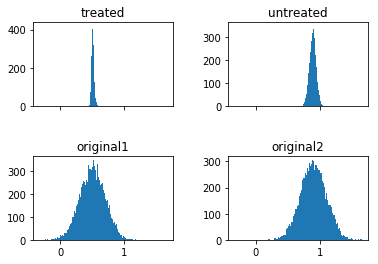

In [396]:
fig2, axes = plt.subplots(2, 2, sharex=True)
plt.subplots_adjust(wspace=0.4, hspace=0.6)
axes[0, 0].hist(gen_pt[1,:], bins=100)
axes[0, 0].set_title('treated')
axes[0, 1].hist(gen_pt[2,:], bins=100) 
axes[0, 1].set_title('untreated')
axes[1, 0].hist(np.random.normal(0.5,0.2,10000),bins=100) 
axes[1, 0].set_title('original1')
axes[1, 1].hist(np.random.normal(0.9,0.2,10000), bins=100) 
axes[1, 1].set_title('original2')
plt.show()

In [397]:
class Estimator(nn.Module):
    def __init__(self, cond_dim, hidden_dim, latent_dim, estimate_dim):
        super(Estimator, self).__init__()
        
        self.fc1 = nn.Linear(latent_dim+cond_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, estimate_dim)
        
    def forward(self,z,y):
        h = F.relu(self.fc1(torch.cat([z,y],1)))
        h = F.relu(self.fc2(h))
        return self.fc3(h)

criterion = nn.MSELoss()
model2 = Estimator(cond_dim, hidden_dim, latent_dim, estimate_dim)
model2.to(device)
optimizer = torch.optim.SGD(model2.parameters(),lr=1e-3)

In [398]:
for epoch in range(1, num_epochs+1):
    for _data in tqdm(train_loader):
        y = _data[:,0]
        x = _data[:,1]
        o = _data[:,2]
        x, y = data_shaper(x, y, input_dim)
        o = o.view(-1, estimate_dim).float()
        x = x.to(device)
        y = y.to(device)
        o = o.to(device)
        
        optimizer.zero_grad()
        
        z = q.sample({"x":x, "y":y}, return_all=False)
        latent = z.get('z')
        output = model2(latent,y)
        loss = criterion(output,o)        
        loss.backward()
        
        optimizer.step()
    
    total = 0
    total_loss = 0
    for _data in test_loader:
        y = _data[:,0]
        x = _data[:,1]
        o = _data[:,2]
        x, y = data_shaper(x, y, input_dim)
        o = o.view(-1, estimate_dim).float()
        x = x.to(device)
        y = y.to(device)
        o = o.to(device)
        
        z = q.sample({"x":x, "y":y}, return_all=False)
        latent = z.get('z')
        output = model2(latent,y)
        loss = criterion(output,o)
        
        total_loss += loss *len(_data)
        total += len(_data)
    test_loss = total_loss/total
    
    print('Epochs:{}, train_Loss:{}, test_Loss:{:.2f}'.format(epoch,loss.item(), test_loss.item()))
    

  8%|▊         | 49/600 [00:00<00:01, 487.99it/s]

Epochs:1, train_Loss:0.8515379428863525, test_Loss:0.79


  8%|▊         | 48/600 [00:00<00:01, 479.76it/s]

Epochs:2, train_Loss:0.7530098557472229, test_Loss:0.68


  8%|▊         | 49/600 [00:00<00:01, 483.68it/s]

Epochs:3, train_Loss:0.5802178382873535, test_Loss:0.56


  8%|▊         | 47/600 [00:00<00:01, 467.07it/s]

Epochs:4, train_Loss:0.3998177647590637, test_Loss:0.38


  8%|▊         | 51/600 [00:00<00:01, 505.88it/s]

Epochs:5, train_Loss:0.2098436951637268, test_Loss:0.21


  8%|▊         | 50/600 [00:00<00:01, 495.76it/s]

Epochs:6, train_Loss:0.13242019712924957, test_Loss:0.11


 10%|█         | 60/600 [00:00<00:00, 599.74it/s]

Epochs:7, train_Loss:0.09806949645280838, test_Loss:0.08


  8%|▊         | 48/600 [00:00<00:01, 475.74it/s]

Epochs:8, train_Loss:0.08023171126842499, test_Loss:0.07


  8%|▊         | 48/600 [00:00<00:01, 470.94it/s]

Epochs:9, train_Loss:0.07305479794740677, test_Loss:0.07


100%|██████████| 600/600 [00:01<00:00, 468.50it/s]


Epochs:10, train_Loss:0.07216130942106247, test_Loss:0.06


In [399]:
pt_size = 10000
z_sample = 1 * torch.randn(pt_size, latent_dim).to(device)

# 非治療群を生成
plot_number = 0
y_sample = torch.eye(2)[[plot_number]*pt_size].to(device)
untreated =  plot_image_from_latent(z_sample,y_sample , output_dim)
untreated_outcome = model2(z_sample, y_sample)
# 治療群を生成
plot_number = 1
y_sample = torch.eye(2)[[plot_number]*pt_size].to(device)
treated =  plot_image_from_latent(z_sample,y_sample , output_dim)
treated_outcome = model2(z_sample, y_sample)

0.25441664
2.0086157


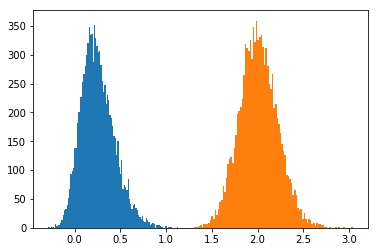

In [421]:
plt.hist(untreated_outcome.cpu().detach().numpy(),bins=100)
print(untreated_outcome.cpu().detach().numpy().mean())
plt.hist(treated_outcome.cpu().detach().numpy(), bins=100)
print(treated_outcome.cpu().detach().numpy().mean())

(array([  1.,   1.,   2.,   3.,   4.,   1.,   6.,   6.,   6.,   8.,  13.,
         20.,  15.,  30.,  22.,  32.,  45.,  49.,  73.,  62.,  87., 111.,
        120., 123., 113., 139., 161., 197., 203., 209., 223., 265., 318.,
        311., 307., 325., 292., 348., 322., 359., 326., 330., 335., 314.,
        282., 312., 280., 249., 240., 267., 208., 215., 190., 180., 164.,
        146., 134., 127.,  92.,  89.,  84.,  77.,  57.,  65.,  56.,  34.,
         31.,  32.,  16.,  26.,  16.,   9.,  16.,  13.,   6.,   9.,   3.,
          9.,   7.,   6.,   4.,   4.,   1.,   1.,   0.,   2.,   0.,   0.,
          0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([1.3039064, 1.3212615, 1.3386166, 1.3559716, 1.3733267, 1.3906817,
        1.4080368, 1.4253919, 1.4427469, 1.460102 , 1.477457 , 1.4948121,
        1.5121672, 1.5295222, 1.5468773, 1.5642323, 1.5815874, 1.5989425,
        1.6162975, 1.6336526, 1.6510077, 1.6683627, 1.6857178, 1.7030728,
        1.7204279, 1.7

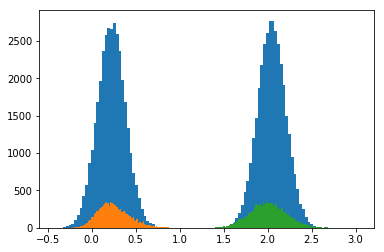

In [401]:
plt.hist(data[:,2],bins=100)
plt.hist(untreated_outcome.cpu().detach().numpy(),bins=100)
plt.hist(treated_outcome.cpu().detach().numpy(),bins=100)

1.7541988

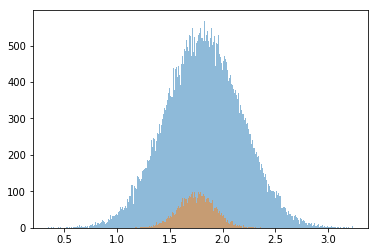

In [402]:
plt.hist(treat_group-untreat_group, bins=300, alpha=0.5)
plt.hist(treated_outcome.cpu().detach().numpy()-untreated_outcome.cpu().detach().numpy(),bins=300,alpha=0.5)
(treated_outcome.cpu().detach().numpy()-untreated_outcome.cpu().detach().numpy()).mean()

In [403]:
x1 = np.ones(70000)
x2 = np.random.normal(x1*3+0.5,0.2)
t_yogo = kaiki(x1,x2)
t_data = np.array((x1,x2,t_yogo)).T
x1= np.zeros(70000)
x2 = np.random.normal(x1*3+0.5,0.2)
u_yogo = kaiki(x1,x2)
u_data = np.array((x1,x2,u_yogo)).T

In [404]:
t_pt_maker = torch.utils.data.DataLoader(dataset=t_data, batch_size = 10000, shuffle=True)
for _data in t_pt_maker:
    y = _data[:,0]-1                         #治療群のラベルを非治療にする
    x = _data[:,1]
    x, y = data_shaper(x,y, input_dim)
    x = x.to(device)
    y = y.to(device)
    o = _data[:,2]
    o = o.view(-1, estimate_dim).float()
    o = o.to(device)
    with torch.no_grad():
        z1 = q.sample({"x": x, "y": y}, return_all=False)
        latent = z1.get('z')
        t_output=model2(latent,y)

0.36898312


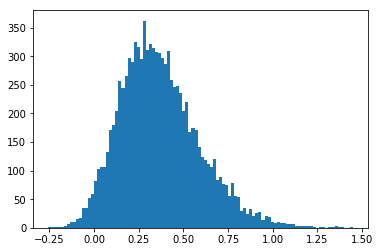

In [405]:
plt.hist(t_output.cpu().numpy(), bins=100)
output_mean=t_output.cpu().numpy().mean()
print(output_mean)

In [406]:
u_pt_maker = torch.utils.data.DataLoader(dataset=u_data, batch_size = 10000, shuffle=True)
for _data in u_pt_maker:
    y = _data[:,0]+1                         #非治療群のラベルを治療にする
    x = _data[:,1]
    x, y = data_shaper(x,y, input_dim)
    x = x.to(device)
    y = y.to(device)
    o = _data[:,2]
    o = o.view(-1, estimate_dim).float()
    o = o.to(device)
    with torch.no_grad():
        z2 = q.sample({"x": x, "y": y}, return_all=False)
        latent = z2.get('z')
        u_output=model2(latent,y)

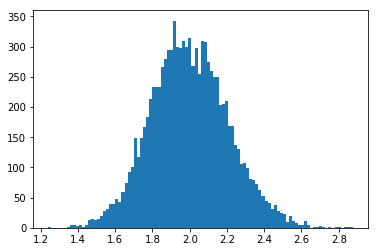

In [407]:
plt.hist(u_output.cpu().numpy(), bins=100)
u_output_mean=u_output.cpu().numpy().mean()

In [408]:
print(treat_group.mean()-output_mean)
print(u_output_mean-untreat_group.mean())
print(((treat_group.mean()-output_mean)+(u_output_mean-untreat_group.mean()))/2)

1.850022814501005
1.599528125983434
1.7247754702422196


(array([  2.,   0.,   0.,   0.,   0.,   0.,   1.,   4.,   5.,   3.,   5.,
          2.,   4.,  13.,  14.,  13.,  15.,  19.,  28.,  31.,  40.,  39.,
         48.,  42.,  60.,  75.,  92., 100., 149., 117., 148., 167., 184.,
        214., 233., 234., 233., 266., 279., 295., 294., 343., 299., 297.,
        310., 300., 314., 268., 297., 254., 310., 307., 275., 259., 250.,
        249., 204., 205., 210., 168., 169., 137., 130., 106., 108.,  99.,
         81.,  80.,  72.,  62.,  53.,  44.,  41.,  31.,  37.,  27.,  24.,
         23.,   9.,  19.,  12.,   8.,   5.,   5.,  11.,   5.,   0.,   1.,
          2.,   3.,   1.,   0.,   2.,   0.,   1.,   1.,   0.,   1.,   1.,
          2.]),
 array([1.2413399, 1.2576824, 1.274025 , 1.2903675, 1.30671  , 1.3230525,
        1.339395 , 1.3557376, 1.3720801, 1.3884226, 1.4047651, 1.4211076,
        1.4374502, 1.4537927, 1.4701352, 1.4864777, 1.5028203, 1.5191628,
        1.5355053, 1.5518478, 1.5681903, 1.5845329, 1.6008754, 1.6172179,
        1.6335604, 1.6

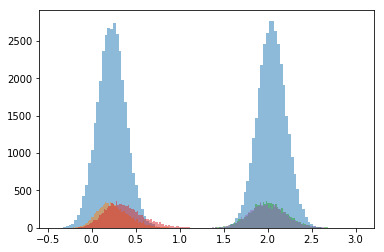

In [409]:
plt.hist(data[:,2],bins=100,alpha=0.5)
plt.hist(untreated_outcome.cpu().detach().numpy(),bins=100,alpha=0.5)
plt.hist(treated_outcome.cpu().detach().numpy(),bins=100,alpha=0.5)
plt.hist(t_output.cpu().numpy(), bins=100,alpha=0.5)
plt.hist(u_output.cpu().numpy(), bins=100,alpha=0.5)

(array([  2.,   0.,   0.,   0.,   0.,   0.,   1.,   4.,   5.,   3.,   5.,
          2.,   4.,  13.,  14.,  13.,  15.,  19.,  28.,  31.,  40.,  39.,
         48.,  42.,  60.,  75.,  92., 100., 149., 117., 148., 167., 184.,
        214., 233., 234., 233., 266., 279., 295., 294., 343., 299., 297.,
        310., 300., 314., 268., 297., 254., 310., 307., 275., 259., 250.,
        249., 204., 205., 210., 168., 169., 137., 130., 106., 108.,  99.,
         81.,  80.,  72.,  62.,  53.,  44.,  41.,  31.,  37.,  27.,  24.,
         23.,   9.,  19.,  12.,   8.,   5.,   5.,  11.,   5.,   0.,   1.,
          2.,   3.,   1.,   0.,   2.,   0.,   1.,   1.,   0.,   1.,   1.,
          2.]),
 array([1.2413399, 1.2576824, 1.274025 , 1.2903675, 1.30671  , 1.3230525,
        1.339395 , 1.3557376, 1.3720801, 1.3884226, 1.4047651, 1.4211076,
        1.4374502, 1.4537927, 1.4701352, 1.4864777, 1.5028203, 1.5191628,
        1.5355053, 1.5518478, 1.5681903, 1.5845329, 1.6008754, 1.6172179,
        1.6335604, 1.6

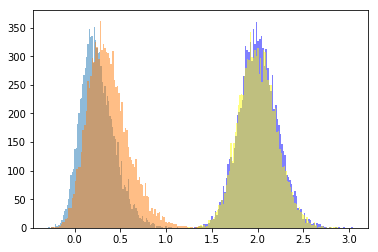

In [410]:
plt.hist(untreated_outcome.cpu().detach().numpy(),bins=100,alpha=0.5)
plt.hist(treated_outcome.cpu().detach().numpy(),bins=100,alpha=0.5,color='blue')
plt.hist(t_output.cpu().numpy(), bins=100,alpha=0.5)
plt.hist(u_output.cpu().numpy(), bins=100,alpha=0.5,color="yellow")

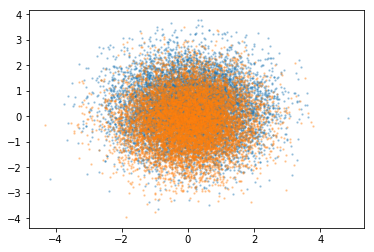

In [411]:
plt.scatter(z1.get('z').cpu().numpy()[:,0],z1.get('z').cpu().numpy()[:,1],s=2,alpha=0.3)
plt.scatter(z2.get('z').cpu().numpy()[:,0],z2.get('z').cpu().numpy()[:,1],s=2,alpha=0.3)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,
          0.,   6.,   5.,   4.,   4.,   6.,   8.,   2.,   4.,   8.,   7.,
         19.,  13.,  16.,  22.,  16.,  40.,  45.,  44.,  61.,  75.,  78.,
         77., 106., 117., 140., 136., 148., 144., 176., 200., 221., 226.,
        255., 216., 270., 318., 255., 299., 332., 296., 338., 310., 316.,
        365., 318., 315., 303., 315., 293., 274., 247., 239., 247., 187.,
        167., 174., 155., 127., 142.,  88., 103.,  96.,  77.,  64.,  50.,
         41.,  40.,  35.,  27.,  20.,  21.,  11.,  16.,  14.,   9.,   7.,
          4.,   8.,   5.,   3.,   2.,   1.,   2.,   1.,   1.,   0.,   1.,
          2.]),
 array([-4.321686  , -4.2405653 , -4.1594453 , -4.078325  , -3.9972048 ,
        -3.9160845 , -3.8349643 , -3.753844  , -3.6727235 , -3.5916033 ,
        -3.510483  , -3.4293628 , -3.3482425 , -3.2671223 , -3.186002  ,
        -3.1048818 , -3.0237615 , -2.9426413 , -2.861521  , -2.7804008 ,
        -2.6992805 , -2.61

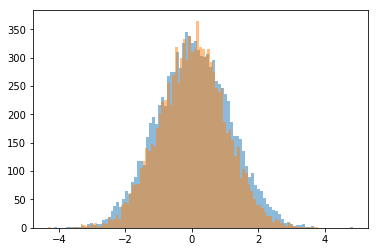

In [417]:
plt.hist(z1.get('z').cpu().numpy()[:,0], bins=100,alpha=0.5)
plt.hist(z2.get('z').cpu().numpy()[:,0], bins=100,alpha=0.5)

(array([  1.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   3.,   2.,   3.,
          2.,   7.,   6.,  11.,   8.,  11.,  11.,  14.,  18.,  30.,  26.,
         22.,  41.,  22.,  39.,  61.,  72.,  57.,  76.,  98., 110.,  89.,
        117., 136., 151., 167., 170., 178., 193., 245., 236., 253., 220.,
        235., 295., 276., 281., 269., 282., 304., 314., 295., 297., 308.,
        280., 243., 255., 244., 248., 269., 237., 190., 190., 194., 172.,
        175., 148., 135., 102., 105., 108.,  84.,  69.,  74.,  56.,  42.,
         45.,  41.,  38.,  43.,  28.,  15.,  17.,  16.,  15.,  11.,   9.,
          4.,  13.,   5.,   3.,   6.,   1.,   1.,   0.,   1.,   1.,   1.,
          1.]),
 array([-3.9628773 , -3.8882651 , -3.8136532 , -3.739041  , -3.6644292 ,
        -3.589817  , -3.5152051 , -3.440593  , -3.365981  , -3.291369  ,
        -3.216757  , -3.142145  , -3.067533  , -2.9929209 , -2.9183087 ,
        -2.8436968 , -2.7690847 , -2.6944728 , -2.6198606 , -2.5452487 ,
        -2.4706366 , -2.39

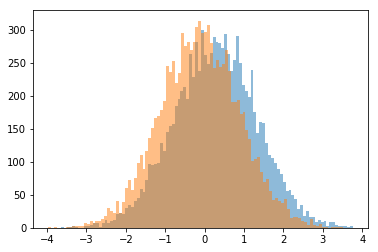

In [418]:
plt.hist(z1.get('z').cpu().numpy()[:,1], bins=100,alpha=0.5)
plt.hist(z2.get('z').cpu().numpy()[:,1], bins=100,alpha=0.5)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,   1.,
          1.,   4.,   2.,   2.,  11.,  11.,  13.,  22.,  12.,  23.,  22.,
         30.,  32.,  44.,  43.,  59.,  59.,  84.,  70.,  92., 111., 127.,
        121., 157., 171., 184., 184., 209., 210., 236., 277., 268., 285.,
        306., 319., 304., 328., 342., 335., 322., 355., 321., 267., 311.,
        292., 277., 230., 258., 244., 230., 209., 187., 174., 157., 147.,
        133.,  97., 106.,  84.,  86.,  61.,  53.,  49.,  41.,  33.,  30.,
         24.,  18.,  21.,  17.,  10.,   7.,   9.,   6.,   2.,   3.,   4.,
          2.,   1.,   2.,   0.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,
          2.]),
 array([-4.0469484 , -3.9654782 , -3.8840082 , -3.802538  , -3.7210677 ,
        -3.6395974 , -3.5581274 , -3.4766572 , -3.395187  , -3.3137167 ,
        -3.2322466 , -3.1507764 , -3.0693061 , -2.987836  , -2.9063659 ,
        -2.8248956 , -2.7434254 , -2.661955  , -2.580485  , -2.4990149 ,
        -2.4175446 , -2.33

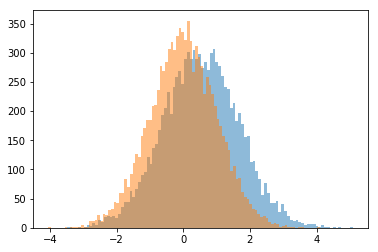

In [419]:
plt.hist(z1.get('z').cpu().numpy()[:,3], bins=100,alpha=0.5)
plt.hist(z2.get('z').cpu().numpy()[:,3], bins=100,alpha=0.5)